In [1]:
cd ../../

/Users/in-divye.singh/Documents/Projects/MIC_predictor


In [2]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from notebooks.utils import *
import importlib
import sys
importlib.reload(sys.modules['notebooks.utils'])
from notebooks.utils import *

In [4]:
from sklearn.manifold import TSNE

In [5]:
avp_ic50 = pd.read_csv("data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("data/raw/HA_AVP.csv")

df = pd.concat([avp_ic50[['Sequence', 'MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)
# df = df.sample(frac=1).reset_index(drop=True)

In [6]:
results = pd.read_csv("results/knn_regressor_all_data_combination.csv", sep=';')

In [7]:
results

,Data,Regressor,Best_parameters,MSE,MAE,MAPE
0,aa_freq,KNN,"""{'metric': 'chebyshev', 'n_neighbors': 1, 'w...",4238.627327,32.290370,4.607780e+06
1,dipep_freq,KNN,"""{'metric': 'euclidean', 'n_neighbors': 1, 'w...",3578.824434,27.736770,4.536848e+06
2,tripep_freq,KNN,"""{'metric': 'chebyshev', 'n_neighbors': 1, 'w...",5870.207139,40.165073,9.121888e+05
3,avg_protvec,KNN,"""{'metric': 'chebyshev', 'n_neighbors': 1, 'w...",5264.466418,32.421390,1.443086e+06
4,physicochemical_prop,KNN,"""{'metric': 'euclidean', 'n_neighbors': 2, 'w...",4032.816185,32.126328,2.141575e+05
5,aa_freq+dipep_freq,KNN,"""{'metric': 'chebyshev', 'n_neighbors': 2, 'w...",2713.243562,28.995829,2.274189e+06
6,aa_freq+tripep_freq,KNN,"""{'metric': 'euclidean', 'n_neighbors': 2, 'w...",3078.615787,27.148469,2.358213e+06
7,aa_freq+avg_protvec,KNN,"""{'metric': 'euclidean', 'n_neighbors': 1, 'w...",3872.983691,29.606011,8.930520e+04
8,aa_freq+physicochemical_prop,KNN,"""{'metric': 'euclidean', 'n_neighbors': 2, 'w...",4032.815319,32.123870,2.141083e+05
9,dipep_freq+tripep_freq,KNN,"""{'metric': 'euclidean', 'n_neighbors': 1, 'w...",3957.573630,28.775896,4.537308e+06


In [8]:
print(f"Best MAPE: {results['MAPE'].min()}")
print(f"Best performing data: {results.loc[results['MAPE'].argmin()]['Data']}")
print(f"Best parameters: {results.loc[results['MAPE'].argmin()]['Best_parameters']}")

Best MAPE: 38427.619517675776
Best performing data: dipep_freq+avg_protvec
Best parameters:  "{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}"


### Analysis

In [9]:
dipep_freq = reduce_by_kmer_frequency(df, kmer=2)

In [10]:
uniprot_embedding = biovec.models.load_protvec("data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1125.60sequence/s]


In [11]:
dipep_protvec = pd.concat([avg_protvec, dipep_freq], axis=1)

In [12]:
from sklearn.neighbors import NearestNeighbors

In [13]:
def plot_nbr_mic(data, target, n_neighbors=1, metric='euclidean', n_jobs=10):
    data = data.reset_index(drop=True)
    target = target.reset_index(drop=True)
    nearesr_neighbors = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=n_jobs)
    nearesr_neighbors.fit(data)
    grph = nearesr_neighbors.kneighbors_graph(n_neighbors=n_neighbors).todense()
    neighbors = np.where(grph == 1)
    neighbors = np.array([[i]+neighbors[1][np.where(neighbors[0]==i)[0]].tolist() for i in range(data.shape[0])])
    mic_nbrs = np.full(neighbors.shape, np.nan)
    for i in range(mic_nbrs.shape[1]):
        mic_nbrs[:,i] = target[neighbors[:,i]]

    plt.figure(figsize=(5*mic_nbrs.shape[1],50))
    im = plt.imshow(mic_nbrs, cmap='gist_ncar', interpolation='none') #plt.cm.get_cmap('gist_rainbow', 75)
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label('MIC', fontsize=25)
    plt.axis('auto')
    plt.xlabel('neighbors', fontdict={'size':5*mic_nbrs.shape[1]})
    plt.ylabel('#row', fontdict={'size':5*mic_nbrs.shape[1]})
    plt.xticks(fontsize=5*mic_nbrs.shape[1])
    plt.yticks(fontsize=5*mic_nbrs.shape[1])
    plt.show()

### Observation

For kNN to give good results, sequences which are closer together should have MIC values closer together. But it is seen from below plot that many of the sequences with higher MIC values have low MIC value sequeces as their neighbors. However, as we look at lower MIC value sequences, they start to have low MIC value sequeces as their neighbors.

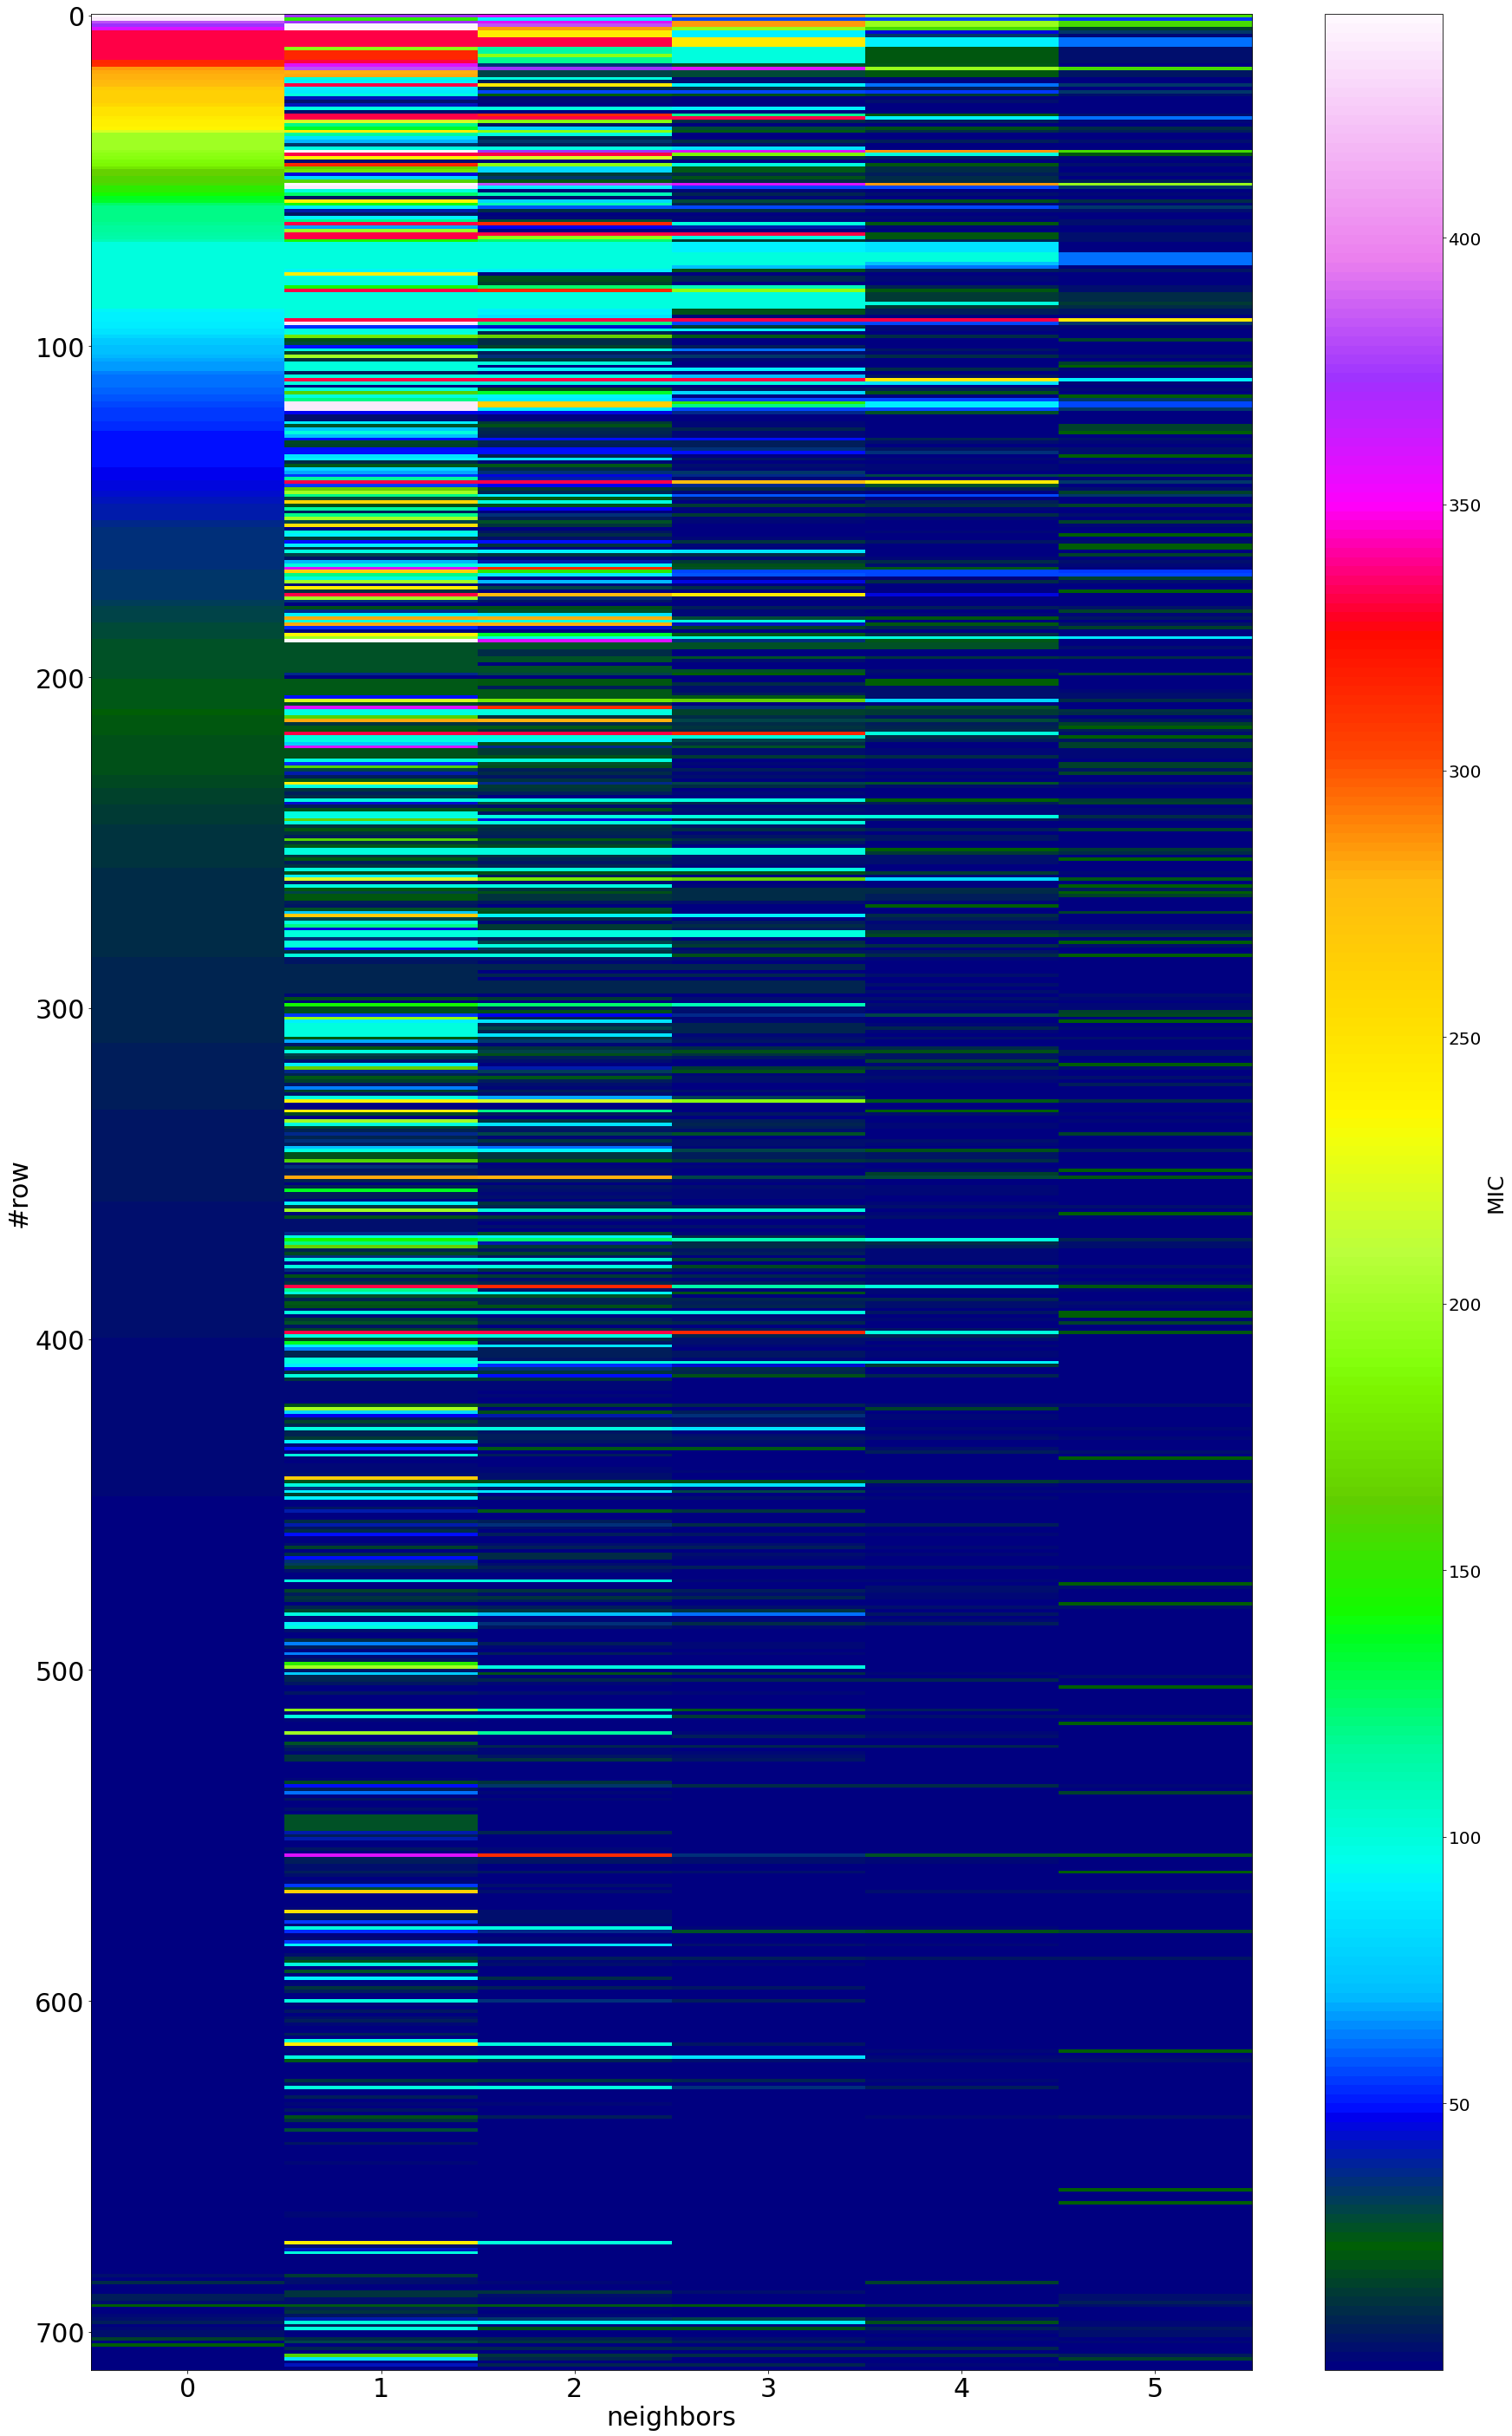

In [27]:
plot_nbr_mic(dipep_protvec, df['MIC'], n_neighbors=5)

In [23]:
mask = df['MIC'] < 5

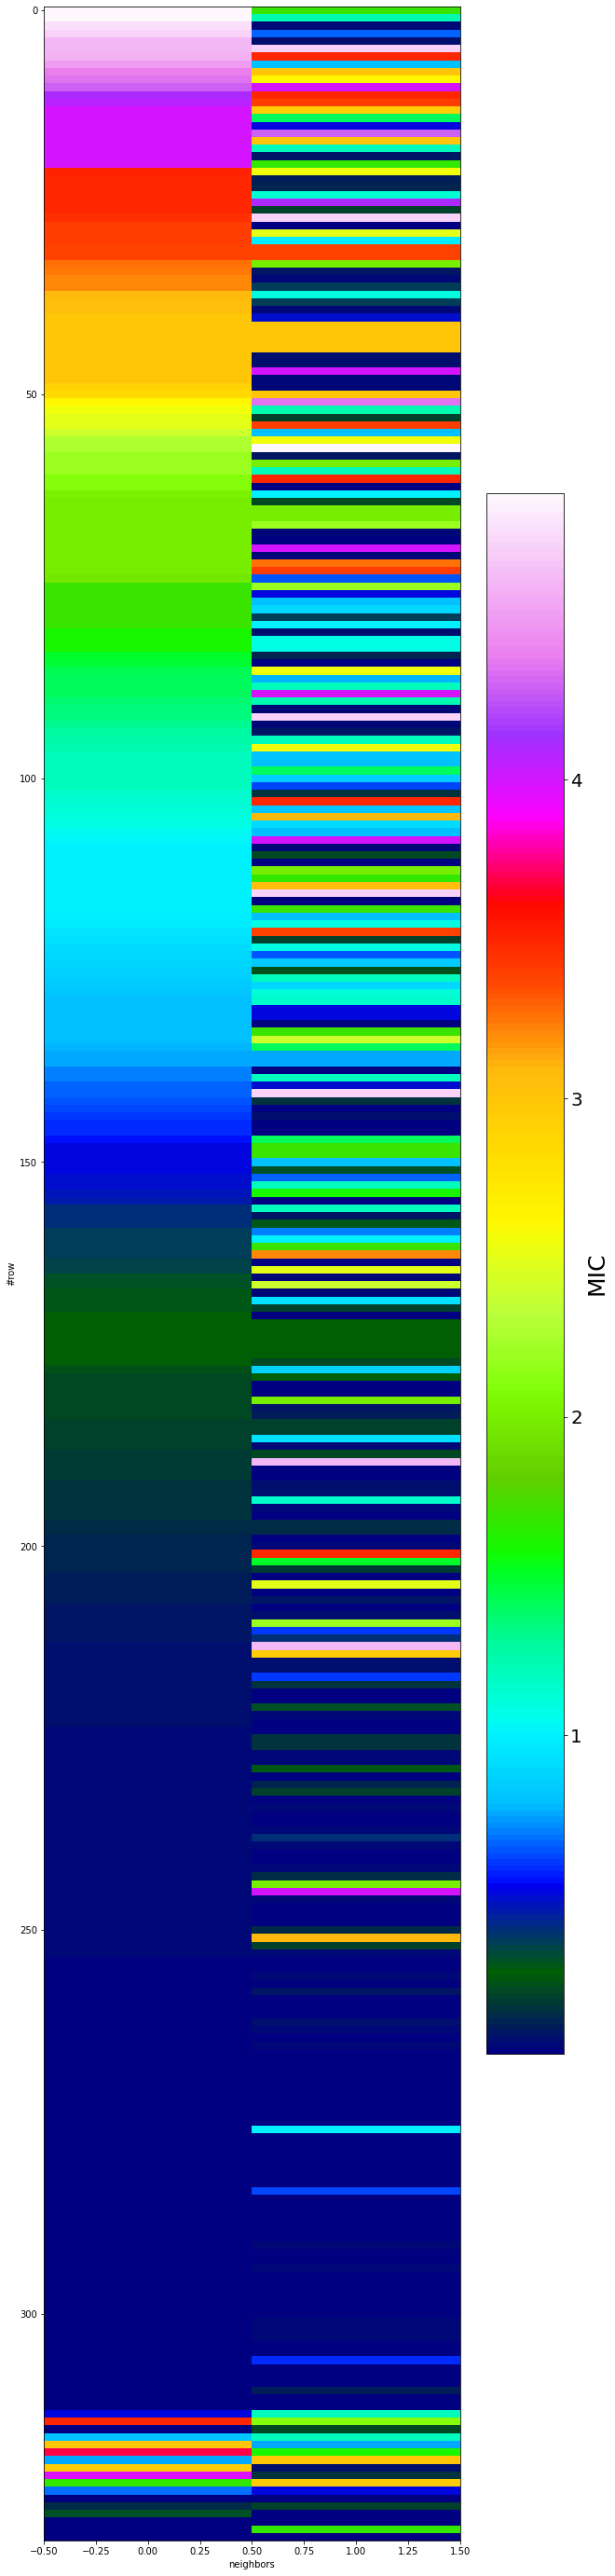

In [24]:
plot_nbr_mic(dipep_protvec[mask], df['MIC'][mask], n_neighbors=1)